In [1]:
import os
import glob
import copy
import math
import matplotlib
import multiprocessing

import numpy as np
import pandas as pd
import scipy.integrate as integrate
import PersistenceImages.persistence_images as pimg

from ripser import Rips
from matplotlib import cm
from scipy.io import loadmat
from scipy.stats import norm
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#### Parse Simulation Data
- Cell Type 1 (40%) - Red (plotted in dark orange)
- Cell Type 2 (60%) - Green (plotted in blue)

In [2]:
def get_sim_data(timefile, simulationtype):
    
    posfilestring = simulationtype + "/" + "Pos_" + str(timefile).zfill(7) +".dat"
    posdata = np.loadtxt(posfilestring, str, "#", ",")
    posx = []
    posy = []
    
    for val in posdata:
        splitpos = val.split("+")
        xpos = ""
        ypos = ""
        if(len(splitpos) == 2):
            xpos = splitpos[0]
            ypos = splitpos[1]
        else:
            minusindex = val[1:].find("-") + 1
            xpos = val[0:minusindex]
            ypos = val[minusindex:]
        ypos = ypos[:-1]
        xpos = [float(xpos)]
        ypos = [float(ypos)]
        posx = np.append(posx, xpos)
        posy = np.append(posy, ypos)   
    positions = np.column_stack((posx, posy))
    typefilestring = simulationtype + "/" + "Types_" + str(timefile).zfill(7) + ".dat"
    typedata = np.loadtxt(typefilestring, int, "#", ",")
    
    return (positions, typedata)

#### Compute Persistence Images

In [3]:
def compute_dim0_img(greenxpos, greenypos, redxpos, redypos, xpos, ypos, max_eps, px_res):
    
    vrc = Rips(maxdim = 0, thresh = max_eps, verbose = False)
    green_diag = vrc.fit_transform(np.transpose(np.array([greenxpos, greenypos])))
    red_diag = vrc.fit_transform(np.transpose(np.array([redxpos, redypos])))
    all_diag = vrc.fit_transform(np.transpose(np.array([xpos, ypos])))
    
    # replace inf with max eps
    # green_diag[0][-1] = [0.0, max_eps]
    # red_diag[0][-1] = [0.0, max_eps]
    # all_diag[0][-1] = [0.0, max_eps]

    # remove inf
    green_diag[0] = green_diag[0][:-1]
    red_diag[0] = red_diag[0][:-1]
    all_diag[0] = all_diag[0][:-1]
    
    pers_imager = pimg.PersistenceImager()
    pers_imager.pixel_size = px_res
    pers_imager.birth_range = (0, 1)
    pers_imager.pers_range = (0, max_eps)
    pers_imager.weight = pimg.weighting_fxns.persistence
    pers_imager.weight_params = {'n': 1}
    pers_imager.kernel_params = {'sigma': 0.05}
    
    green_pers_img = pers_imager.transform(green_diag[0], skew=False)
    red_pers_img = pers_imager.transform(red_diag[0], skew=False)
    all_pers_img = pers_imager.transform(all_diag[0], skew=False)
    
    return (green_pers_img, red_pers_img, all_pers_img)

def compute_pers_img(greenxpos, greenypos, redxpos, redypos, xpos, ypos, dim, max_eps, px_res):
    
    if dim == 0:
        return compute_dim0_img(greenxpos, greenypos, redxpos, redypos, xpos, ypos, max_eps, px_res)
    
    vrc = Rips(maxdim = dim, thresh = max_eps, verbose = False)
    green_diag = vrc.fit_transform(np.transpose(np.array([greenxpos, greenypos])))
    red_diag = vrc.fit_transform(np.transpose(np.array([redxpos, redypos])))
    all_diag = vrc.fit_transform(np.transpose(np.array([xpos, ypos])))
    
    pers_imager = pimg.PersistenceImager()
    pers_imager.pixel_size = px_res
    pers_imager.birth_range = (0, max_eps)
    pers_imager.pers_range = (0, max_eps/2)
    pers_imager.weight = pimg.weighting_fxns.persistence
    pers_imager.weight_params = {'n': 1}
    pers_imager.kernel_params = {'sigma': 0.05}
    # print(pers_imager)
    
    green_pers_img = pers_imager.transform(green_diag[dim], skew=True)
    red_pers_img = pers_imager.transform(red_diag[dim], skew=True)
    all_pers_img = pers_imager.transform(all_diag[dim], skew=True)
    
    return (green_pers_img, red_pers_img, all_pers_img)

def save_persimg(dim0_imgs, dim1_imgs, dim2_imgs, ofolder, ofilename):

    green_img_dim0, red_img_dim0, all_img_dim0 = dim0_imgs
    green_img_dim1, red_img_dim1, all_img_dim1 = dim1_imgs
    green_img_dim2, red_img_dim2, all_img_dim2 = dim2_imgs
    
    save_data = dict()
    save_data['H0'] = np.vstack([np.mean(green_img_dim0, axis=0), 
                                 np.mean(red_img_dim0, axis=0), 
                                 np.mean(all_img_dim0, axis=0)])
    save_data['H1'] = np.vstack([green_img_dim1.flatten(), 
                                 red_img_dim1.flatten(), 
                                 all_img_dim1.flatten()])
    save_data['H2'] = np.vstack([green_img_dim2.flatten(), 
                                 red_img_dim2.flatten(), 
                                 all_img_dim2.flatten()])
    
    with open(ofolder + os.sep + ofilename, 'wb') as fh:
        np.save(fh, save_data)
        
def visualize(posdata, dim0_imgs, dim1_imgs, dim2_imgs, max_eps, px_res, ofolder, ofilename):
    
    greenxpos, greenypos, redxpos, redypos = posdata
    green_img_dim0, red_img_dim0, all_img_dim0 = dim0_imgs
    green_img_dim1, red_img_dim1, all_img_dim1 = dim1_imgs
    green_img_dim2, red_img_dim2, all_img_dim2 = dim2_imgs
    
    green_intensity_vals = np.mean(green_img_dim0, axis=0)
    red_intensity_vals = np.mean(red_img_dim0, axis=0)
    all_intensity_vals = np.mean(all_img_dim0, axis=0)
    
    white = np.array([1.0, 1.0, 1.0, 1.0])
    reds_cmap = cm.get_cmap('Oranges', 20)
    redcolors = reds_cmap(range(12))
    redcolors[0, :] = white
    red_cmp = ListedColormap(redcolors)
    
    greens_cmap = cm.get_cmap('Blues', 20)
    greencolors = greens_cmap(range(12))
    greencolors[0, :] = white
    green_cmp = ListedColormap(greencolors)
        
    xs = range(0, int(max_eps/px_res))
    xs = [x*px_res for x in xs]
    xs = np.round(xs, decimals=2)
    
    plt.figure(figsize=(12,10), dpi=200)
    
    plt.subplot(221)
    plt.scatter(greenxpos, greenypos, s=3, color='blue')
    plt.scatter(redxpos, redypos, s=3, color='darkorange')
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    
    plt.subplot(222)
    plt.plot(xs, green_intensity_vals, color='blue')
    plt.plot(xs, red_intensity_vals, color='darkorange')
    plt.plot(xs, all_intensity_vals, color='gray')
    plt.xlabel('$H_0$ Interval Length', size=12)
    plt.ylabel('Image Intensity $\propto$ Interval Length', size=12)
    plt.xlim([0, max_eps])
    # plt.ylim([0, max_eps/2])
    
    plt.subplot(223)
    h1_c1 = plt.contour(np.transpose(green_img_dim1), cmap=green_cmp)
    h1_c2 = plt.contour(np.transpose(red_img_dim1), cmap=red_cmp)
    plt.xlabel('$H_1$ Interval Start ($\epsilon$)', size=12)
    plt.ylabel('$H_1$ Interval Length', size=12)
    xlocs, xlabels = plt.xticks() 
    ylocs, ylabels = plt.yticks() 
    plt.xticks(xlocs, [int(tl*px_res) for tl in xlocs])
    plt.yticks(ylocs, [int(tl*px_res) for tl in ylocs])
    plt.xlim([0, max_eps/px_res])
    plt.ylim([0, max_eps/(2*px_res)])
    c1_lvls = h1_c1.levels
    c2_lvls = h1_c2.levels
    ax = plt.gca()
    if len(c1_lvls) > 1:
        axins1 = inset_axes(ax, width="35%", height="5%", loc='upper left', borderpad=2)
        h1_c1_norm = matplotlib.colors.Normalize(vmin=h1_c1.cvalues.min(), vmax=h1_c1.cvalues.max())
        h1_c1_sm = cm.ScalarMappable(norm=h1_c1_norm, cmap = h1_c1.cmap)
        h1_c1_sm.set_array([])
        plt.colorbar(h1_c1_sm, cax=axins1, orientation="horizontal", 
                     ticks=[np.min(c1_lvls), c1_lvls[int(len(c1_lvls)/2)], np.max(c1_lvls)])
    if len(c2_lvls) > 1:
        axins2 = inset_axes(ax, width="35%", height="5%", loc='upper right', borderpad=2)
        h1_c2_norm = matplotlib.colors.Normalize(vmin=h1_c2.cvalues.min(), vmax=h1_c2.cvalues.max())
        h1_c2_sm = cm.ScalarMappable(norm=h1_c2_norm, cmap = h1_c2.cmap)
        h1_c2_sm.set_array([])
        plt.colorbar(h1_c2_sm, cax=axins2, orientation="horizontal",
                     ticks=[np.min(c2_lvls), c2_lvls[int(len(c2_lvls)/2)], np.max(c2_lvls)])
    
    plt.subplot(224)
    h2_c1 = plt.contour(np.transpose(green_img_dim2), cmap=green_cmp)
    h2_c2 = plt.contour(np.transpose(red_img_dim2), alpha=0.5, cmap=red_cmp)
    plt.xlabel('$H_2$ Interval Start ($\epsilon$)', size=12)
    plt.ylabel('$H_2$ Interval Length', size=12)
    xlocs, xlabels = plt.xticks() 
    ylocs, ylabels = plt.yticks()
    plt.xticks(xlocs, [int(tl*px_res) for tl in xlocs])
    plt.yticks(ylocs, [int(tl*px_res) for tl in ylocs])
    plt.xlim([0, max_eps/px_res])
    plt.ylim([0, max_eps/(2*px_res)])
    c1_lvls = h2_c1.levels
    c2_lvls = h2_c2.levels
    ax = plt.gca()
    if len(c1_lvls) > 1:
        axins1 = inset_axes(ax, width="35%", height="5%", loc='upper left', borderpad=2)
        h2_c1_norm = matplotlib.colors.Normalize(vmin=h2_c1.cvalues.min(), vmax=h2_c1.cvalues.max())
        h2_c1_sm = cm.ScalarMappable(norm=h2_c1_norm, cmap = h2_c1.cmap)
        h2_c1_sm.set_array([])
        plt.colorbar(h2_c1_sm, cax=axins1, orientation="horizontal", 
                     ticks=[np.min(c1_lvls), c1_lvls[int(len(c1_lvls)/2)], np.max(c1_lvls)])
    if len(c2_lvls) > 1:
        axins2 = inset_axes(ax, width="35%", height="5%", loc='upper right', borderpad=2)
        h2_c2_norm = matplotlib.colors.Normalize(vmin=h2_c2.cvalues.min(), vmax=h2_c2.cvalues.max())
        h2_c2_sm = cm.ScalarMappable(norm=h2_c2_norm, cmap = h2_c2.cmap)
        h2_c2_sm.set_array([])
        plt.colorbar(h2_c2_sm, cax=axins2, orientation="horizontal",
                     ticks=[np.min(c2_lvls), c2_lvls[int(len(c2_lvls)/2)], np.max(c2_lvls)])
    
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.savefig(ofolder + os.sep + ofilename)
    
    # plt.close()
    plt.show()

#### Compute Persistence Curves

In [4]:
def calc_barcode(greenxpos, greenypos, redxpos, redypos, xpos, ypos, dim, max_eps):
    
    vrc = Rips(maxdim = dim, thresh = max_eps, verbose = False)
    green_diag = vrc.fit_transform(np.transpose(np.array([greenxpos, greenypos])))[dim].tolist()
    red_diag = vrc.fit_transform(np.transpose(np.array([redxpos, redypos])))[dim].tolist()
    all_diag = vrc.fit_transform(np.transpose(np.array([xpos, ypos])))[dim].tolist()
    
    return (green_diag, red_diag, all_diag)

def compute_norm_betti_persistence_curve(barcode, step, curve_max):
    
    linetraverse = np.arange(0, curve_max, step)
    curvvalues = []
    totalpoints = len(barcode)
    
    for i in linetraverse:
        value = 0
        for(a,b) in barcode:
            if((a < i) & (b > i)):
                value = value + 1
        curvvalues.append(value/totalpoints)
        
    return (linetraverse, curvvalues)

def compute_norm_life_persistence_curve(barcode, step, curve_max):
    
    linetraverse = np.arange(0, curve_max, step)
    curvvalues = []
    totallife = 0
    for(c,d) in barcode:
           totallife = totallife + d - c
    for i in linetraverse:
        value = 0
        for(a,b) in barcode:
            if((a < i) & (b > i)):
                value = value + b - a
        curvvalues.append(value)
    normval = [x / totallife for x in curvvalues]
    
    return (linetraverse, normval)

def compute_k_landscape_persistence_curve(barcode, step, curve_max):
    
    linetraverse = np.arange(0, curve_max, step)
    curvvalues = []
    totalpoints = len(barcode)
    for i in linetraverse:
        max = 0;
        for(a,b) in barcode:
            l = 0
            if((a < i) & (b > i)):
                if(i <= (a+b)/2):
                    l = i - a
                else:
                    l = b - i
            if(l > max):
                max = l
        curvvalues.append(max)
        
    return (linetraverse, curvvalues)

def make_gauss(xmu, ymu, sigma):
    
    A = 1.0/(2*math.pi*sigma)
    s = -1.0/(2*sigma*sigma)
    
    def f(x,y):
        return A * math.exp(s * ((x-xmu)*(x-xmu) + (y-ymu)*(y-ymu)))
    
    return f

def compute_gauss_persistence_curve(barcode, delta_eps, eps_max, sigma):
    
    linetraverse = np.arange(0, eps_max, delta_eps)
    curvvalues = []
    funclist = []
    
    for (c, d) in barcode:
        funclist.append(make_gauss(c, d, sigma))
    
    gaussfunc = lambda x,y: sum(phi(x,y) for phi in funclist)
    
    for i in linetraverse:
        ans, err = integrate.dblquad(gaussfunc, 0, i, i, eps_max)
        curvvalues.append(ans)
        
    curvvalues = np.asarray(curvvalues)
    
    return (linetraverse, curvvalues)

def fast_gauss_persistence_curve(barcode, delta_eps, eps_max, sigma):
    
    eps_vals = np.arange(0, eps_max, delta_eps)
    
    perscurve_vals = []
    
    for t in eps_vals:
        
        acc = 0.0
        
        num_bars = len(barcode)
        
        for (c, d) in barcode:
            
            gauss_cdf_birth = norm.cdf(t, loc=c, scale=sigma)
            gauss_cdf_death = norm.cdf(t, loc=d, scale=sigma)
            
            acc = acc + gauss_cdf_birth*(1.0-gauss_cdf_death)
        
        if num_bars > 0:
            perscurve_vals.append(acc/num_bars)
        else:
            perscurve_vals.append(acc)
        
    return (eps_vals, perscurve_vals)

def save_perscurve(dim0_curves, dim1_curves, dim2_curves, ofolder, ofilename):
    
    green_curve_dim0, red_curve_dim0, all_curve_dim0 = dim0_curves
    green_curve_dim1, red_curve_dim1, all_curve_dim1 = dim1_curves
    green_curve_dim2, red_curve_dim2, all_curve_dim2 = dim2_curves
    
    save_data = dict()
    save_data['H0'] = np.vstack([green_curve_dim0, red_curve_dim0, all_curve_dim0])
    save_data['H1'] = np.vstack([green_curve_dim1, red_curve_dim1, all_curve_dim1])
    save_data['H2'] = np.vstack([green_curve_dim2, red_curve_dim2, all_curve_dim2])
    
    with open(ofolder + os.sep + ofilename, 'wb') as fh:
        np.save(fh, save_data)
        
def visualize_perscurve(eps_vals, dim0_curves, dim1_curves, dim2_curves, ofolder, ofilename):
    
    green_curve_dim0, red_curve_dim0, all_curve_dim0 = dim0_curves
    green_curve_dim1, red_curve_dim1, all_curve_dim1 = dim1_curves
    green_curve_dim2, red_curve_dim2, all_curve_dim2 = dim2_curves
    
    plt.figure(figsize=(12,10), dpi=200)
    
    plt.subplot(221)
    plt.plot(eps_vals, green_curve_dim0, 'blue')
    plt.plot(eps_vals, red_curve_dim0, 'darkorange')
    plt.plot(eps_vals, all_curve_dim0, 'gray')
    plt.xlabel('$\epsilon$', size=14)
    plt.ylabel('NPC$(t; H_0)$', size=12)
    plt.xlim([0, 10])
    plt.ylim([0, 1])

    plt.subplot(222)
    plt.plot(eps_vals, green_curve_dim1, 'blue')
    plt.plot(eps_vals, red_curve_dim1, 'darkorange')
    plt.plot(eps_vals, all_curve_dim1, 'gray')
    plt.xlabel('$\epsilon$', size=14)
    plt.ylabel('NPC$(t; H_1)$', size=12)
    plt.xlim([0, 10])
    plt.ylim([0, 1])

    plt.subplot(223)
    plt.plot(eps_vals, green_curve_dim2, 'blue')
    plt.plot(eps_vals, red_curve_dim2, 'darkorange')
    plt.plot(eps_vals, all_curve_dim2, 'gray')
    plt.xlabel('$\epsilon$', size=14)
    plt.ylabel('NPC$(t; H_2)$', size=12)
    plt.xlim([0, 10])
    plt.ylim([0, 1])

    plt.savefig(ofolder + os.sep + ofilename)
    
    # plt.close()
    plt.show()

#### Compute TDA Features

In [5]:
foldername = "ParamSweep_36_Output"

perscurve_output_folder = foldername + "_perscurve"
perscurve_save_folder = foldername + "_perscurve_serialize"
persimg_output_folder = foldername + "_persimg"
persimg_save_folder = foldername + "_persimg_serialize"

if not os.path.isdir(perscurve_output_folder):
    os.mkdir(perscurve_output_folder)
    
if not os.path.isdir(perscurve_save_folder):
    os.mkdir(perscurve_save_folder)
    
if not os.path.isdir(persimg_output_folder):
    os.mkdir(persimg_output_folder)
    
if not os.path.isdir(persimg_save_folder):
    os.mkdir(persimg_save_folder)
    
pos_file_list = glob.glob(foldername + os.sep + "Pos_*.dat")

frame_values = []
for pos_file in pos_file_list:
    fname = pos_file.split(os.sep)[1]
    bname = fname.split(".")[0]
    frame_values.append(int(bname.split("_")[1]))
    
frame_values.sort()
frame = max(frame_values)

In [6]:
max_eps = 10
px_res = 0.1
gauss_sigma = 0.05
delta_eps = 0.05

In [7]:
(cell_pos, cell_type) = get_sim_data(frame, foldername)

xpos = cell_pos[:,0]
ypos = cell_pos[:,1]

reds = cell_type == 1
greens = cell_type == 2

greenxpos = xpos[greens]
greenypos = ypos[greens]
redxpos = xpos[reds]
redypos = ypos[reds]

# print("Processing frame: " + repr(frame))

/home/labmember/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:153: UserWarning: No contour levels were found within the data range.


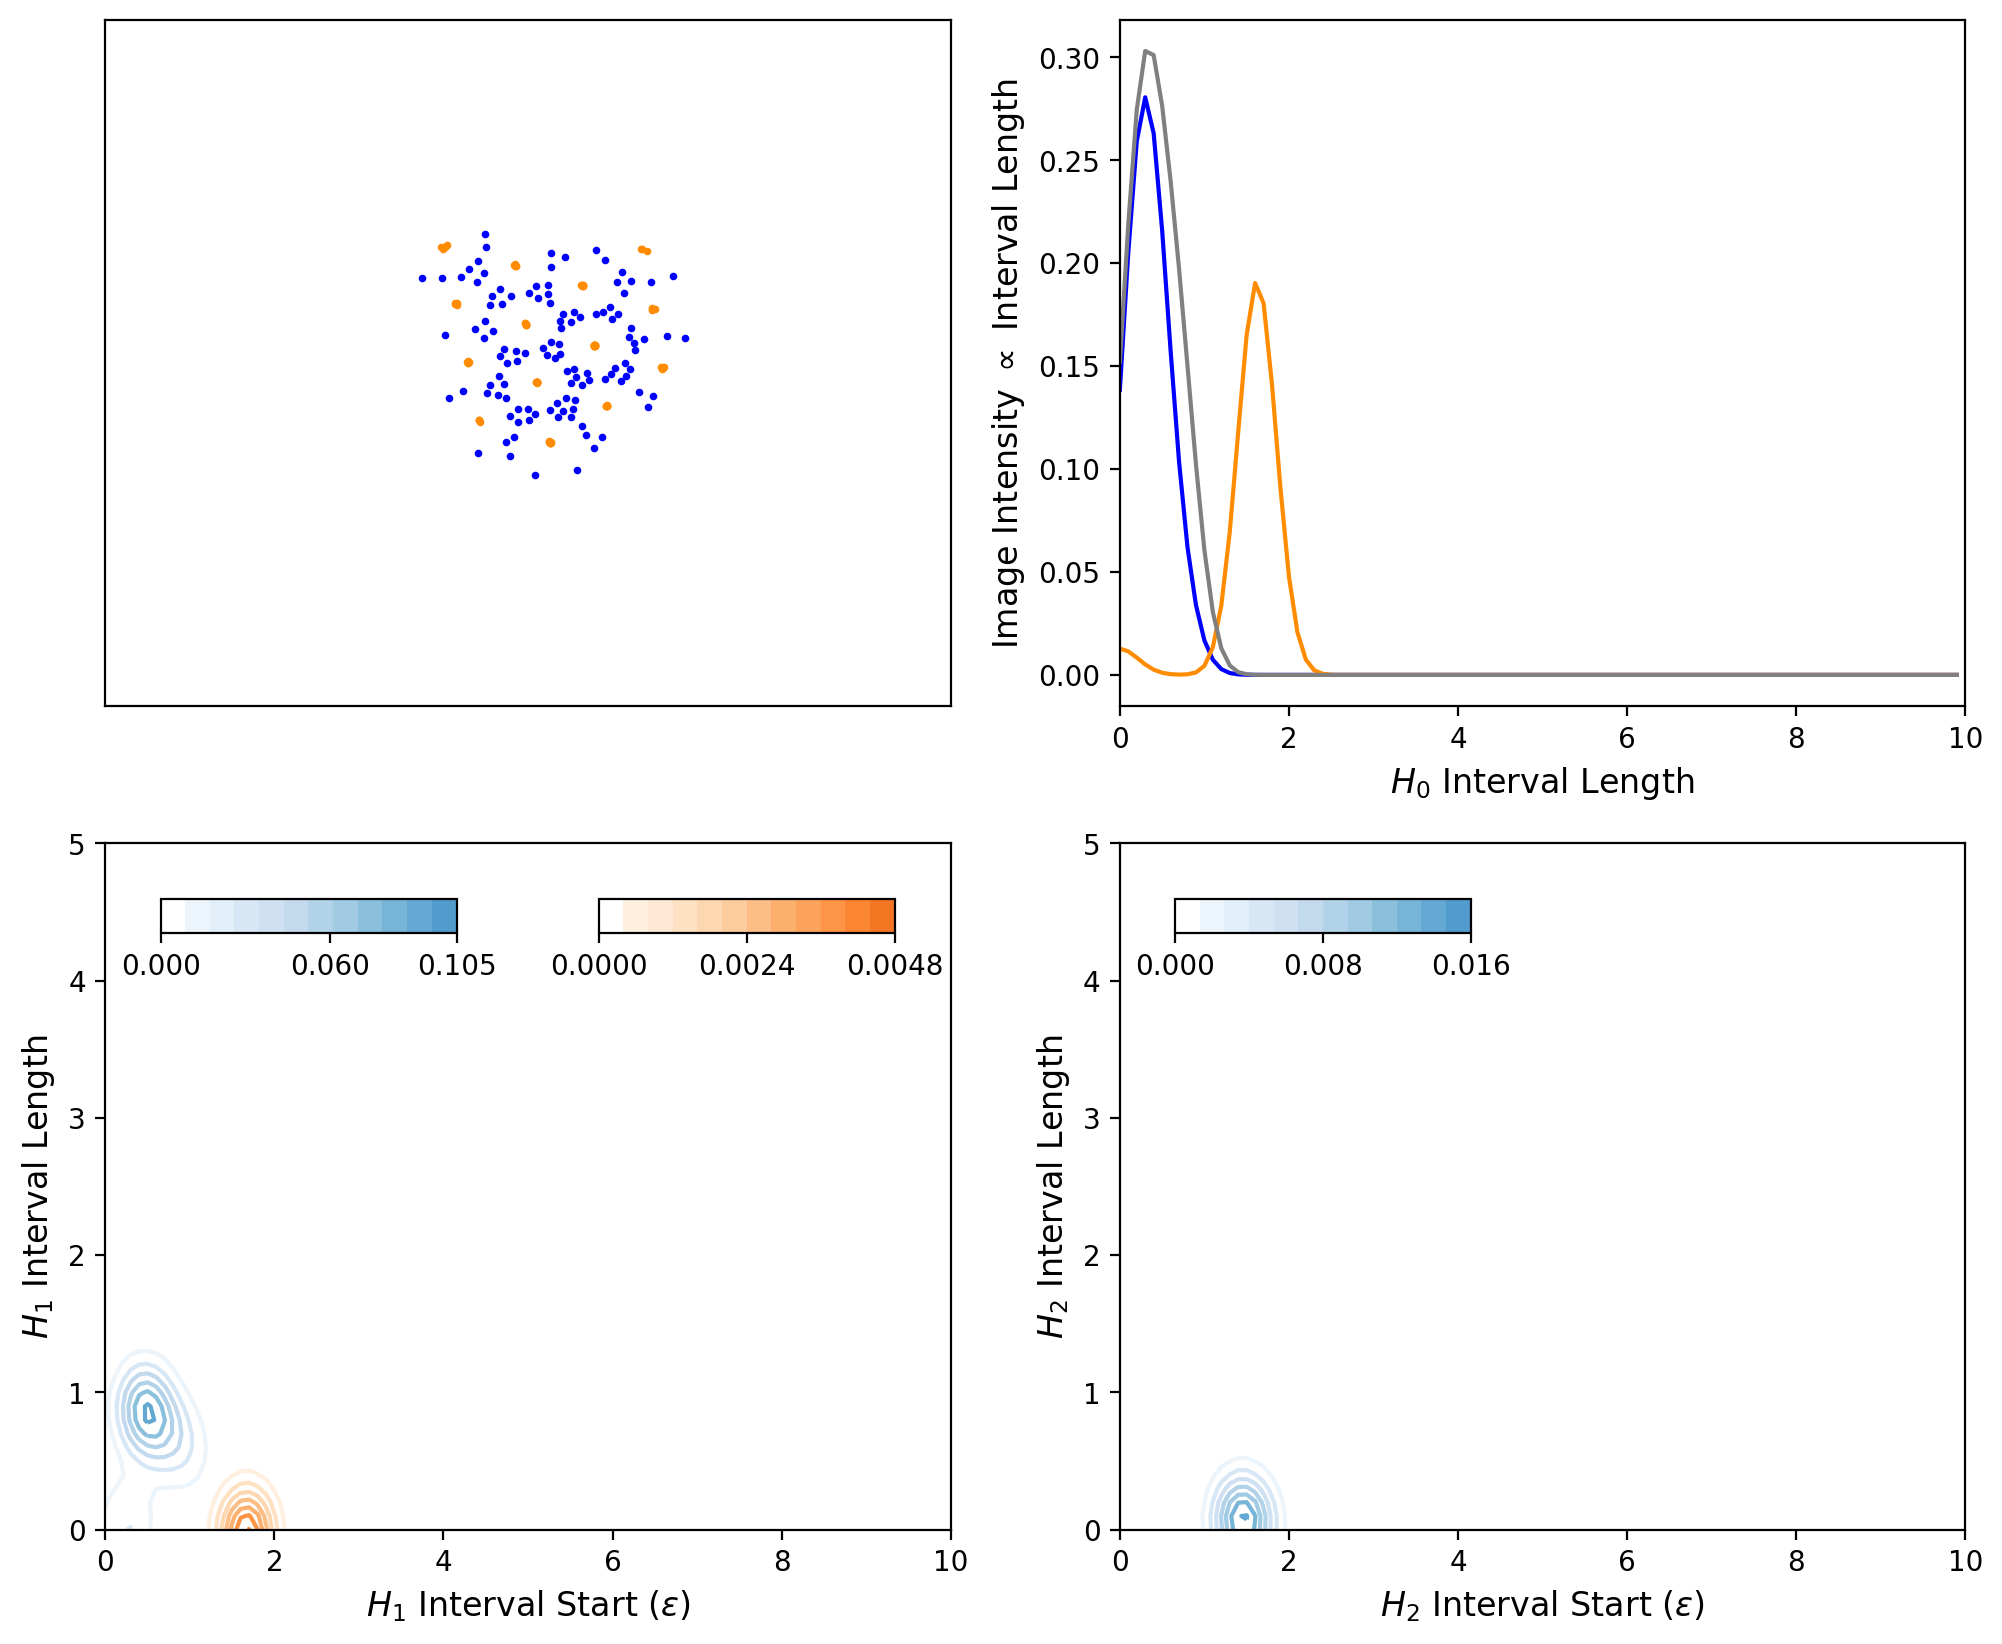

In [8]:
# compute persistence images

(green_img_dim0, red_img_dim0, all_img_dim0) = compute_pers_img(greenxpos, greenypos, redxpos, redypos, 
                                                                xpos, ypos, 0, max_eps, px_res)

(green_img_dim1, red_img_dim1, all_img_dim1) = compute_pers_img(greenxpos, greenypos, redxpos, redypos, 
                                                                xpos, ypos, 1, max_eps, px_res)

(green_img_dim2, red_img_dim2, all_img_dim2) = compute_pers_img(greenxpos, greenypos, redxpos, redypos, 
                                                                xpos, ypos, 2, max_eps, px_res)
        
# visualize persistence images
visualize([greenxpos, greenypos, redxpos, redypos], 
          [green_img_dim0, red_img_dim0, all_img_dim0], 
          [green_img_dim1, red_img_dim1, all_img_dim1], 
          [green_img_dim2, red_img_dim2, all_img_dim2],
          max_eps, px_res, persimg_output_folder, repr(frame).zfill(7) + ".png")

# save persistence images
save_persimg([green_img_dim0, red_img_dim0, all_img_dim0], 
             [green_img_dim1, red_img_dim1, all_img_dim1], 
             [green_img_dim2, red_img_dim2, all_img_dim2],
             persimg_save_folder, repr(frame).zfill(7) + ".npy")

** Definition: ** Gaussian Persistence Curve (smooth Betti curve)

- Specify 2-D gaussian kernel $g_{\mathbf{\mu},\Sigma}(\mathbf{x}) = \frac{\text{exp}(-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^T\Sigma^{-1}(\mathbf{x}-\mathbf{\mu}))}{2\pi |\Sigma|^{1/2}}$
- Given persistence diagram $\mathcal{D}$ corresponding to the $n^\text{th}$ homology group, define persistence curve:

$$ \text{PC}(t; H_n) = \int_t^{\infty} \int_{-\infty}^t \sum_{(b,d)\in\mathcal{D}} g_{(b,d),\Sigma}(x,y) dx dy \quad \text{for} \quad t \in [0, \epsilon_{\text{max}}]$$

- Assume: $\Sigma = \sigma^2 \cdot I_2$ 
- Specify 1-D gaussian $g_{\mu,\sigma^2}(x) = \frac{1}{\sqrt{2\pi}\sigma}\text{exp}\Big(-\frac{1}{2}\frac{(x-\mu)^2}{\sigma^2}\Big)$ with c.d.f $G_{\mu,\sigma^2}(x) = \int_{-\infty}^x g_{\mu,\sigma^2}(\tilde{x}) d\tilde{x}$
- Persistence curve is given by:

$$ \text{PC}(t; H_n) = \sum_{(b,d)\in\mathcal{D}}G_{b,\sigma^2}(t)(1-G_{d,\sigma^2}(t)) \quad \text{for} \quad t \in [0, \epsilon_{\text{max}}]$$

- Define normalized persistence curve:

$$ \text{NPC}(t; H_n) = \begin{cases}
      \frac{1}{|\mathcal{D}|} \text{PC}(t; H_n), & \text{if}\ |\mathcal{D}|>0 \\
      0, & \text{otherwise}
    \end{cases} $$

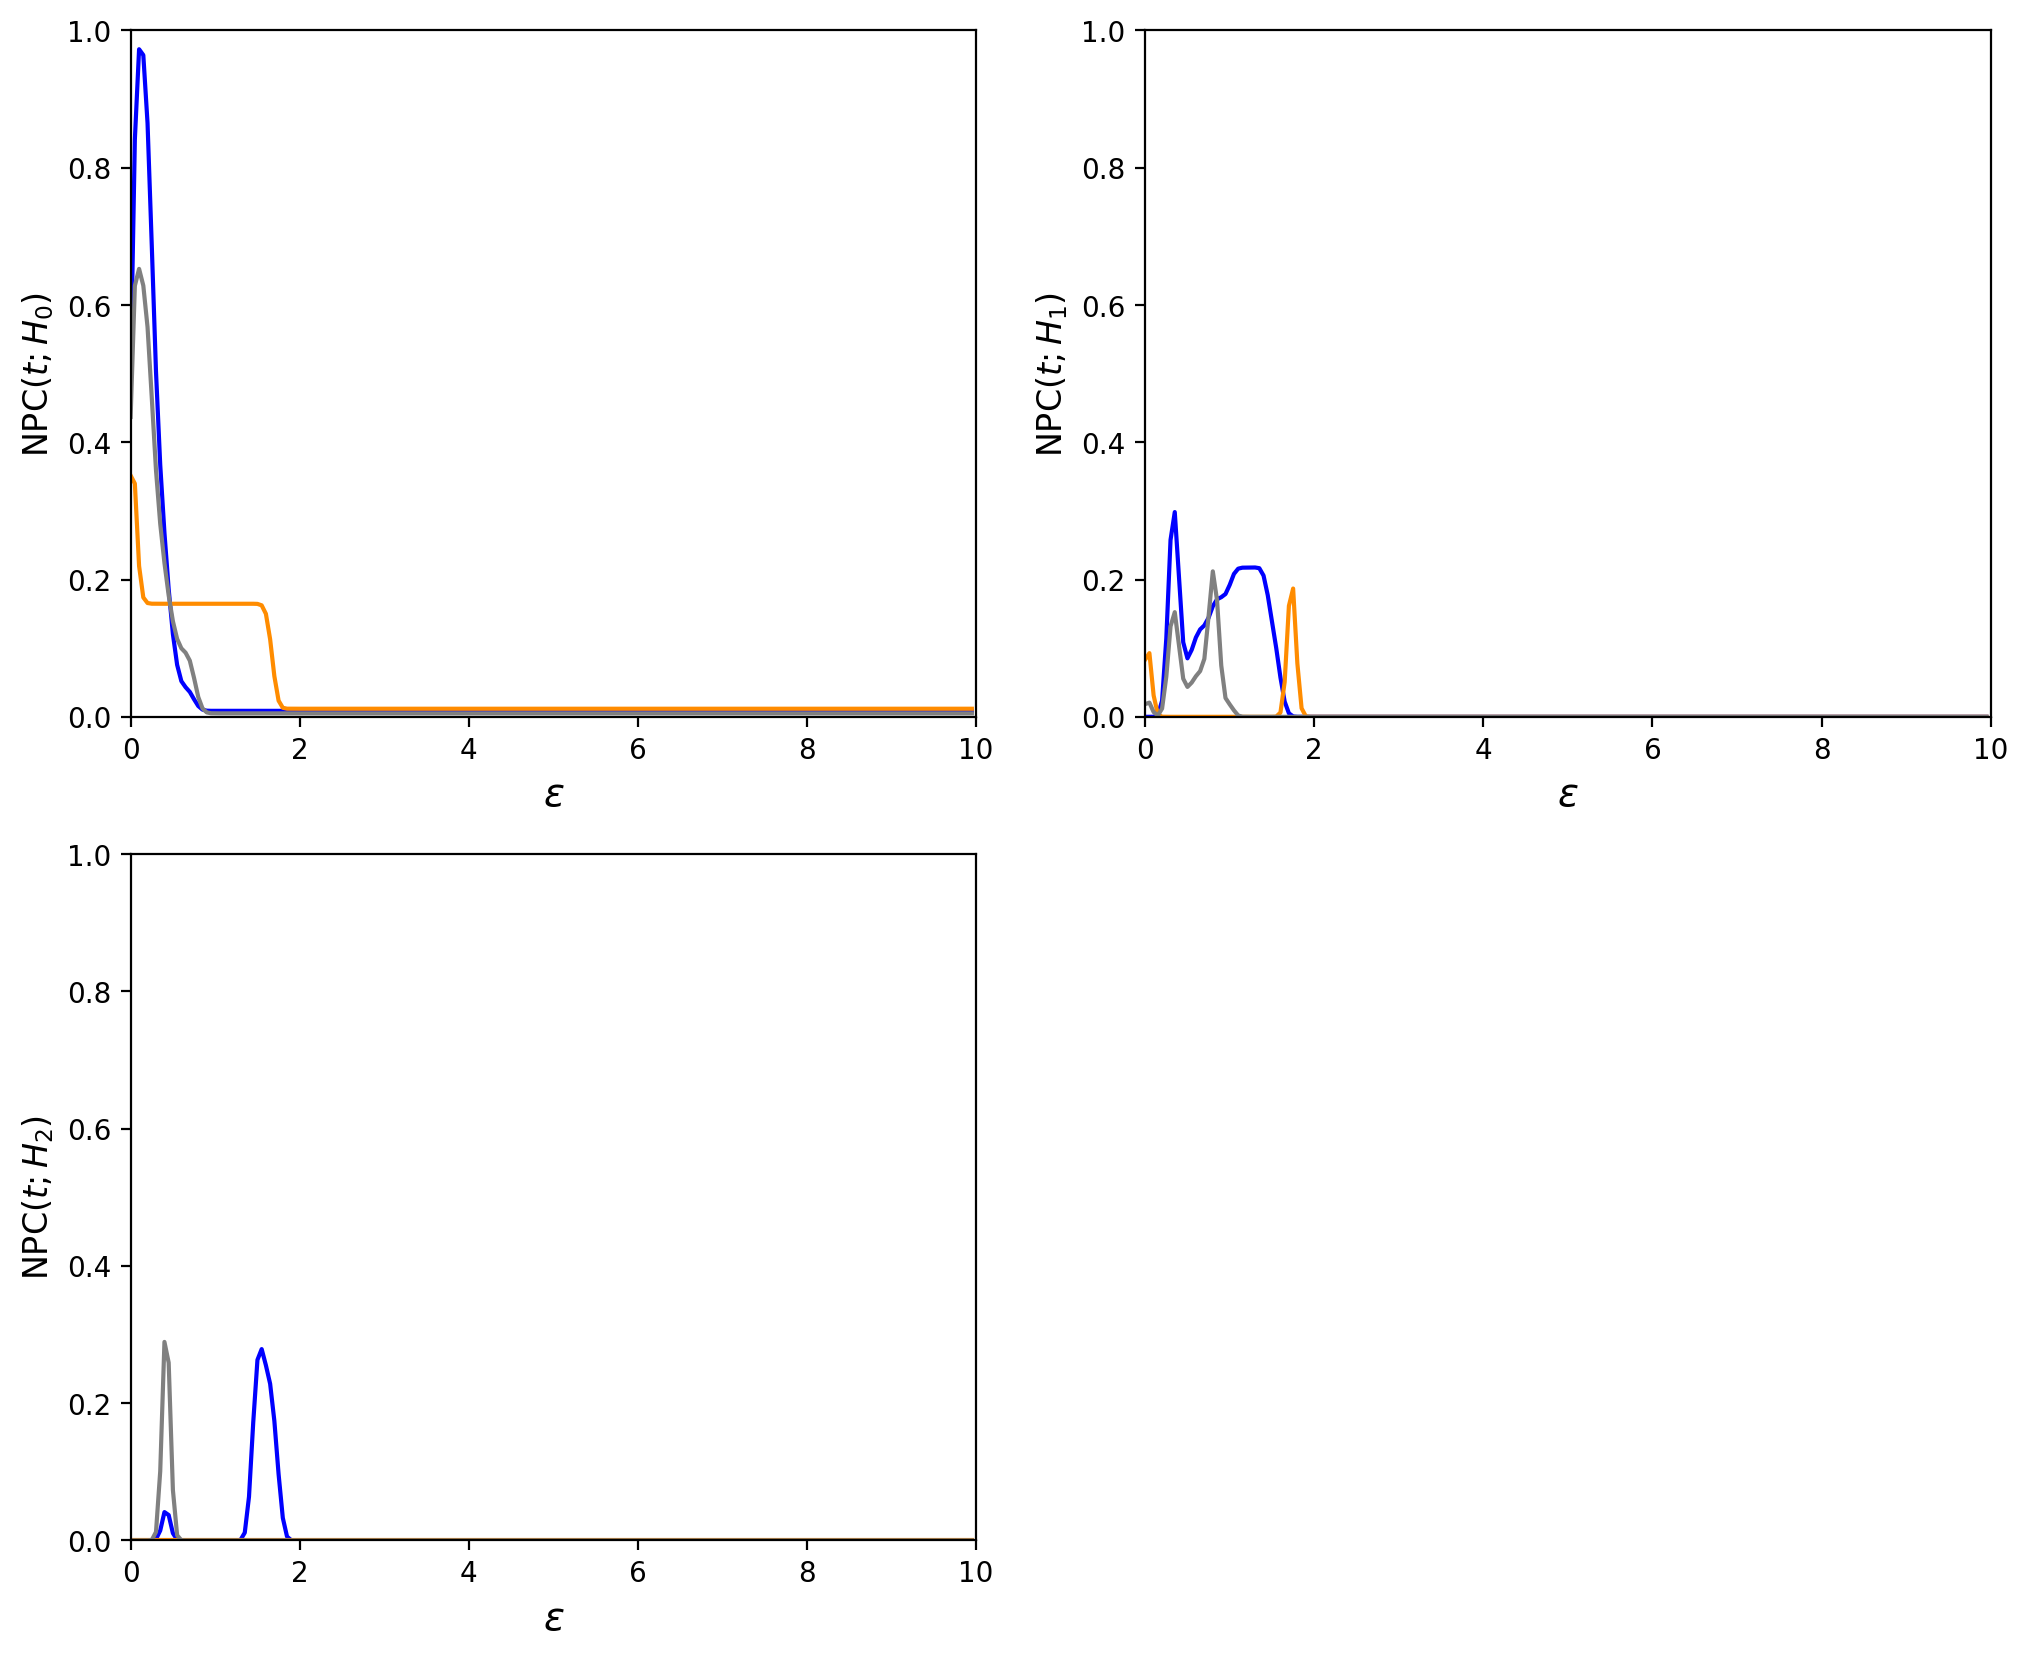

In [9]:
# compute persistence curves

green_diag_dim0, red_diag_dim0, all_diag_dim0 = calc_barcode(greenxpos, greenypos, redxpos, 
                                                             redypos, xpos, ypos, 0, max_eps)
green_diag_dim1, red_diag_dim1, all_diag_dim1 = calc_barcode(greenxpos, greenypos, redxpos, 
                                                             redypos, xpos, ypos, 1, max_eps)
green_diag_dim2, red_diag_dim2, all_diag_dim2 = calc_barcode(greenxpos, greenypos, redxpos, 
                                                             redypos, xpos, ypos, 2, max_eps)

eps, green_perscurve_dim0 = fast_gauss_persistence_curve(green_diag_dim0, delta_eps, max_eps, gauss_sigma)
eps, red_perscurve_dim0 = fast_gauss_persistence_curve(red_diag_dim0, delta_eps, max_eps, gauss_sigma)
eps, all_perscurve_dim0 = fast_gauss_persistence_curve(all_diag_dim0, delta_eps, max_eps, gauss_sigma)

eps, green_perscurve_dim1 = fast_gauss_persistence_curve(green_diag_dim1, delta_eps, max_eps, gauss_sigma)
eps, red_perscurve_dim1 = fast_gauss_persistence_curve(red_diag_dim1, delta_eps, max_eps, gauss_sigma)
eps, all_perscurve_dim1 = fast_gauss_persistence_curve(all_diag_dim1, delta_eps, max_eps, gauss_sigma)

eps, green_perscurve_dim2 = fast_gauss_persistence_curve(green_diag_dim2, delta_eps, max_eps, gauss_sigma)
eps, red_perscurve_dim2 = fast_gauss_persistence_curve(red_diag_dim2, delta_eps, max_eps, gauss_sigma)
eps, all_perscurve_dim2 = fast_gauss_persistence_curve(all_diag_dim2, delta_eps, max_eps, gauss_sigma)

# visualize persistence curves
visualize_perscurve(eps, [green_perscurve_dim0, red_perscurve_dim0, all_perscurve_dim0], 
                    [green_perscurve_dim1, red_perscurve_dim1, all_perscurve_dim1], 
                    [green_perscurve_dim2, red_perscurve_dim2, all_perscurve_dim2], 
                    perscurve_output_folder, repr(frame).zfill(7) + ".png")

# save persistence curves
save_perscurve([green_perscurve_dim0, red_perscurve_dim0, all_perscurve_dim0], 
               [green_perscurve_dim1, red_perscurve_dim1, all_perscurve_dim1], 
               [green_perscurve_dim2, red_perscurve_dim2, all_perscurve_dim2], 
               perscurve_save_folder, repr(frame).zfill(7) + ".npy")